## **MLP para classificação (binária) multiclasse de imagens**
**Dataset Fashion-MNIST**
- Dataset de imagens de peças de vestuário
- Imagens de 28x28 pixeis
- 70k imagens das quais 60k são para treino e 10k para teste
- 10 classes e 785 atributos (o 1º é a classe a classificar o tipo de vestuário e as restantes são valores dos pixéis das imagens)
- Classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag e Ankle boot
    
Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## Imports

In [114]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
    
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [115]:
import random
# a divisão de treino e validação depende da aleatoriedade
# devemos sempre que possível colocar seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

PATH = './'
PATH_TRAIN = './fashion-mnist_train.csv'
PATH_TEST = './fashion-mnist_test.csv'

device = torch.device("cpu")

BATCH_SIZE = 40
EPOCHS = 50
LEARNING_RATE = 0.001

## 1. Preparar os Dados

In [116]:
class CSVDataset(Dataset):
    def __init__(self, path_train, path_test):
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')

    def __len_train__(self):
        return len(self.x_train)

    def __len_test__(self):
        return len(self.x_test)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]

    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    def get_splits_flat(self):
        x_train  = torch.from_numpy(np.array(self.x_train))
        y_train  = torch.from_numpy(np.array(self.y_train))
        x_test  = torch.from_numpy(np.array(self.x_test))
        y_test  = torch.from_numpy(np.array(self.y_test))
        train = torch.utils.data.TensorDataset(x_train,y_train)
        test = torch.utils.data.TensorDataset(x_test,y_test)
        return train, test 
    
def prepare_data_flat(path_train, path_test):
    dataset = CSVDataset(path_train, path_test)
    train, test = dataset.get_splits_flat()

    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [117]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)
def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:60000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([70, 784]), output: torch.Size([70])
Shape tensor batch casos test, input: torch.Size([70, 784]), output: torch.Size([70])
tensor([9, 8, 4, 1, 4, 4, 3, 8, 2, 3, 9, 5, 7, 1, 8, 1, 1, 8, 2, 7, 4, 1, 4, 0,
        7, 4, 2, 8, 1, 4, 6, 5, 6, 9, 6, 8, 0, 4, 5, 1, 6, 6, 8, 4, 5, 5, 5, 1,
        1, 8, 8, 1, 1, 9, 2, 8, 4, 8, 2, 8, 5, 9, 5, 7, 5, 6, 2, 2, 7, 9])


torch.Size([70, 784])
torch.Size([70, 1, 28, 28])


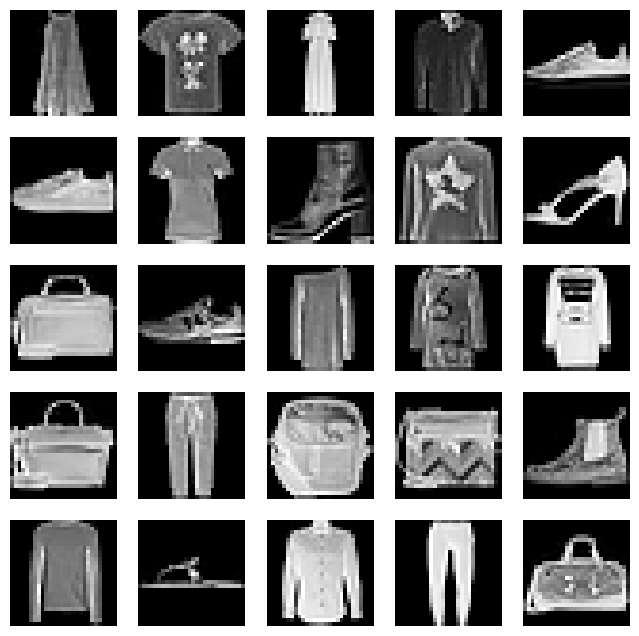

In [118]:
def visualize_mnist_images_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid()
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images_flat(train_dl)

## 1.2 Verificar balanceamento do dataset

-----casos_treino------
casos: 60000
['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/Top', 'Trouser']
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
60000


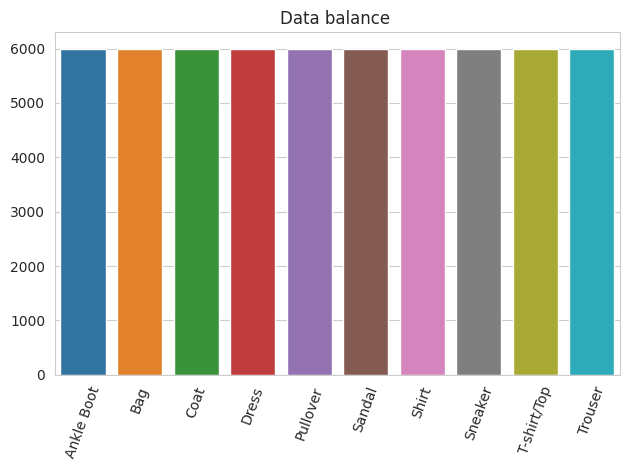

-----casos_teste------
casos: 10000
['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/Top', 'Trouser']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


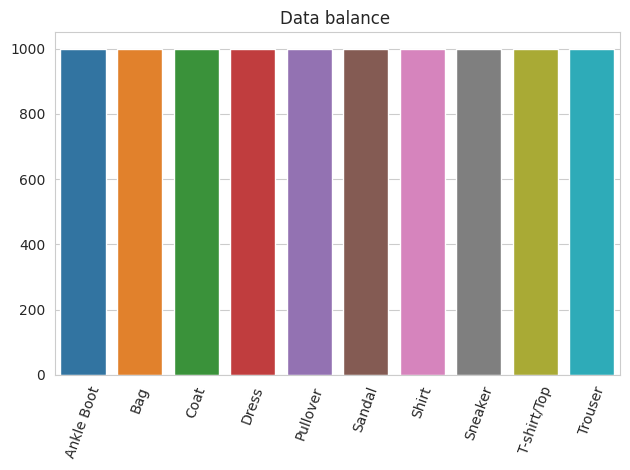

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

def output_label(label):
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress", 4: "Coat", 5: "Sandal",
                       6: "Shirt", 7: "Sneaker", 8: "Bag",
                       9: "Ankle Boot" }
    
    output_mapping2 = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
                        5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
    3: "Dress", 4: "Coat", 5: "Sandal",
    6: "Shirt", 7: "Sneaker", 8: "Bag",
    9: "Ankle Boot" }
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    label_names = [output_mapping[label.item()] for label in labels]
    x, y = np.unique(label_names, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

print("-----casos_treino------")   
visualize_holdout_balance(train_dl_all)
print("-----casos_teste------") 
visualize_holdout_balance(test_dl_all)

## 2. Definir o Modelo

In [120]:
class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 128)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(128, 64)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(64, 32)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        self.hidden4 = Linear(32, 16)
        kaiming_uniform_(self.hidden4.weight, nonlinearity='relu')
        self.act4 = ReLU()
        self.hidden5 = Linear(16, 10)
        kaiming_uniform_(self.hidden5.weight, nonlinearity='relu')
        self.act5 = ReLU()
        self.hidden6 = Linear(10, 10)
        xavier_uniform_(self.hidden6.weight)
        self.act6 = Softmax()

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        X = self.hidden5(X)
        X = self.act5(X)
        X = self.hidden6(X)
        X = self.act6(X)
        return X
    
model = MLP(784)
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [70, 10]                  --
├─Linear: 1-1                            [70, 128]                 100,480
├─ReLU: 1-2                              [70, 128]                 --
├─Linear: 1-3                            [70, 64]                  8,256
├─ReLU: 1-4                              [70, 64]                  --
├─Linear: 1-5                            [70, 32]                  2,080
├─ReLU: 1-6                              [70, 32]                  --
├─Linear: 1-7                            [70, 16]                  528
├─ReLU: 1-8                              [70, 16]                  --
├─Linear: 1-9                            [70, 10]                  170
├─ReLU: 1-10                             [70, 10]                  --
├─Linear: 1-11                           [70, 10]                  110
├─Softmax: 1-12                          [70, 10]                  --
T

/tmp/ipykernel_26663/3278050184.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act6(X)


MLP(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=64, out_features=32, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=32, out_features=16, bias=True)
  (act4): ReLU()
  (hidden5): Linear(in_features=16, out_features=10, bias=True)
  (act5): ReLU()
  (hidden6): Linear(in_features=10, out_features=10, bias=True)
  (act6): Softmax(dim=None)
)

## 3. Treinar o Modelo

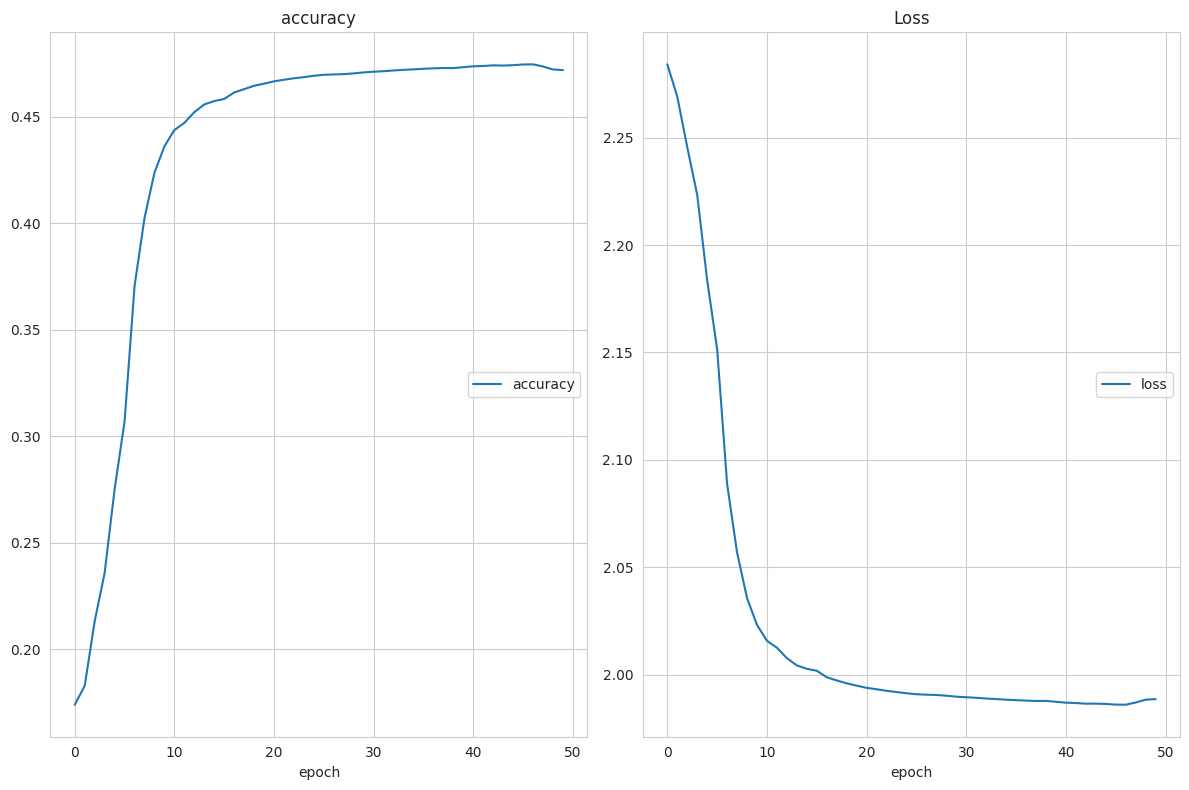

accuracy
	accuracy         	 (min:    0.174, max:    0.475, cur:    0.472)
Loss
	loss             	 (min:    1.986, max:    2.284, cur:    1.989)


In [121]:
from torchinfo import summary
#versão com display de gráfico
from livelossplot import PlotLosses

def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl_all, model)

## 4. Avaliar o Modelo

/tmp/ipykernel_26663/3278050184.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act6(X)


Accuracy: 0.469

acertou:4693 falhou:5307
              precision    recall  f1-score   support

           0       0.31      0.95      0.47      1000
           1       0.61      0.96      0.75      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.59      0.95      0.72      1000
           8       0.43      0.95      0.60      1000
           9       0.58      0.88      0.70      1000

    accuracy                           0.47     10000
   macro avg       0.25      0.47      0.32     10000
weighted avg       0.25      0.47      0.32     10000

[[949  12   0   0   0   0   0   1  35   3]
 [ 32 962   0   0   0   0   0   1   4   1]
 [595   9   0   0   0   0   0   9 339  48]
 [484 499   0   0   0   0   0   1  12   4]
 [377  85   0   0   0   0  

/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/purp/anaconda3/envs/deepl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hom

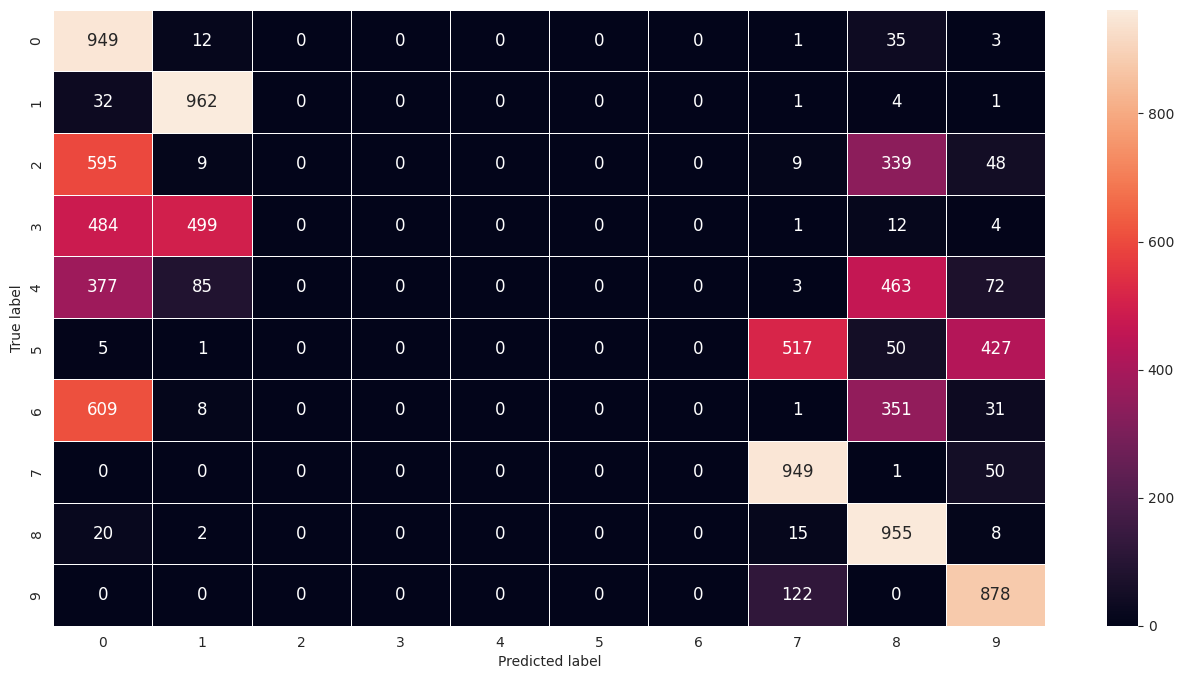

In [122]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
actual_values, predictions = evaluate_model(test_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

torch.Size([70, 784])
torch.float32
predict: 0


/tmp/ipykernel_26663/3278050184.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act6(X)


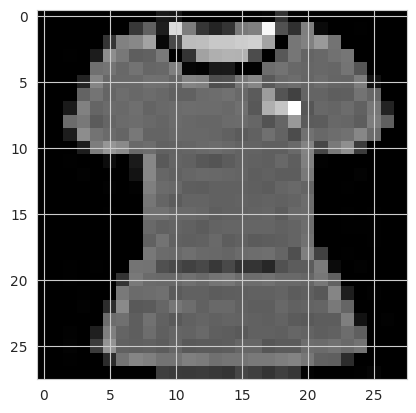

In [123]:
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()
    
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)